In [1]:
import os
import xml.etree.ElementTree as et
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import requests
import yaml
from astropy import units as u
from IPython.display import Image, display
from tardis import run_tardis
import TARDIS_Spectrum_Filtering as tsf

/home/clyde/miniforge3/envs/tardis-installation-test/lib/python3.13/site-packages/tardis/__init__.py:17: UserWarning: Astropy is already imported externally. Astropy should be imported after TARDIS.
  warnings.warn(


Filter URL is valid. Downloading filter file.


In [2]:
# Run TARDIS Simulation

config_file_path = "../../tardis_example.yml"
sim = run_tardis(config_file_path,
                 virtual_packet_logging=True,
                 show_convergence_plots=False,
                 export_convergence_plots=False,
                 log_level="ERROR")

spectrum = sim.spectrum_solver.spectrum_real_packets
spectrum_virtual = sim.spectrum_solver.spectrum_virtual_packets
spectrum_integrated = sim.spectrum_solver.spectrum_integrated

Auto-detected VSCode environment


Auto-detected VSCode environment


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

Initializing tabulator and plotly panel extensions for widgets to work


Embedding the final state for Jupyter environments
[py.warnings         ][WARNING]  /home/clyde/miniforge3/envs/tardis-installation-test/lib/python3.13/site-packages/astropy/units/format/generic.py:507: UnitsWarning:

'erg/s/Hz' contains multiple slashes, which is discouraged by the FITS standard

 (warnings.py:110)


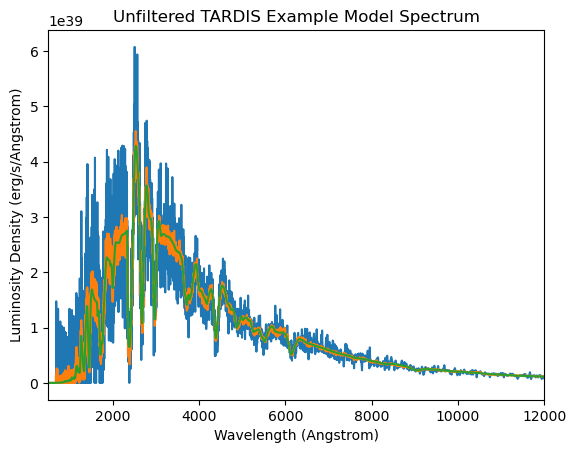

In [3]:
# Plotting the original TARTDIS Example Spectrum

tsf.plot_original_spectrum(spectrum, spectrum_virtual, spectrum_integrated)

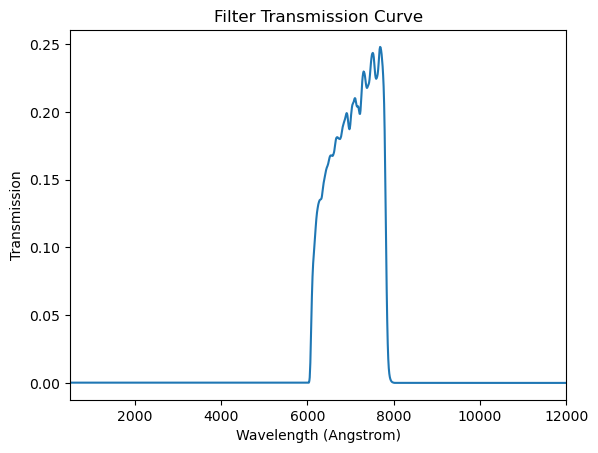

In [ ]:
# Plotting the filter we will apply to the TARDIS Spectrum (The filter chosen in the Config file)

tsf.plot_filter(spectrum, tsf.chosen_filter)

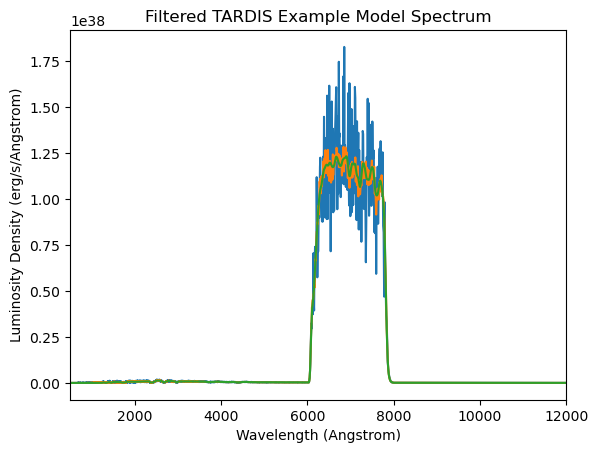

In [ ]:
# Plotting a filtered TARTDIS Example Spectrum
# This is what the TARDIS Spectrum would look like if observed through the chosen filter

tsf.plot_filtered_spectrum(spectrum, spectrum_virtual, spectrum_integrated, tsf.chosen_filter)